Epoch [1000/10000], NLL: 18333.2070
Epoch [2000/10000], NLL: 18332.9629
Epoch [3000/10000], NLL: 18332.9629
Epoch [4000/10000], NLL: 18332.9629
Epoch [5000/10000], NLL: 18332.9629
Epoch [6000/10000], NLL: 18332.9629
Epoch [7000/10000], NLL: 18332.9629
Epoch [8000/10000], NLL: 18332.9629
Epoch [9000/10000], NLL: 18332.9629
Epoch [10000/10000], NLL: 18332.9629
Training completed in 9.73 seconds
Learned parameters:
β = [-0.11677523702383041, 0.11852678656578064]
σ = 1.5134
True parameters:
β = [-0.11146711558103561, 0.12036294490098953]
σ = 1.5000


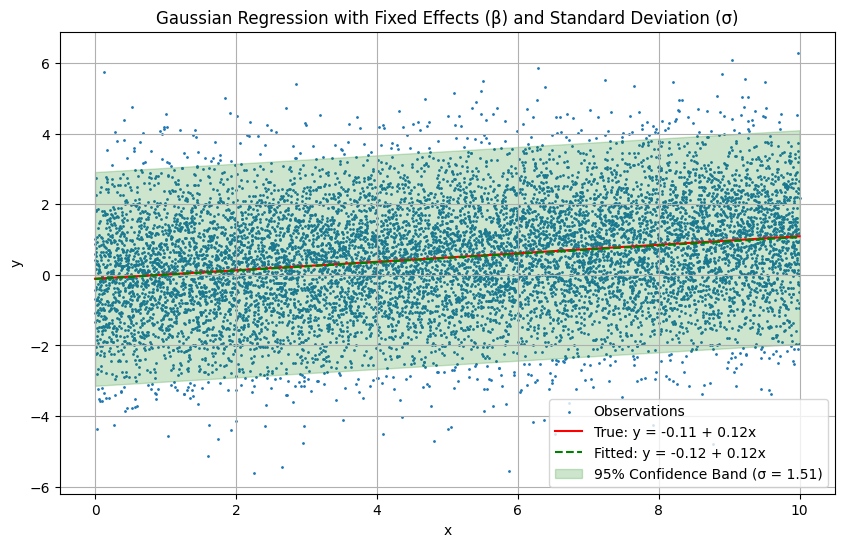

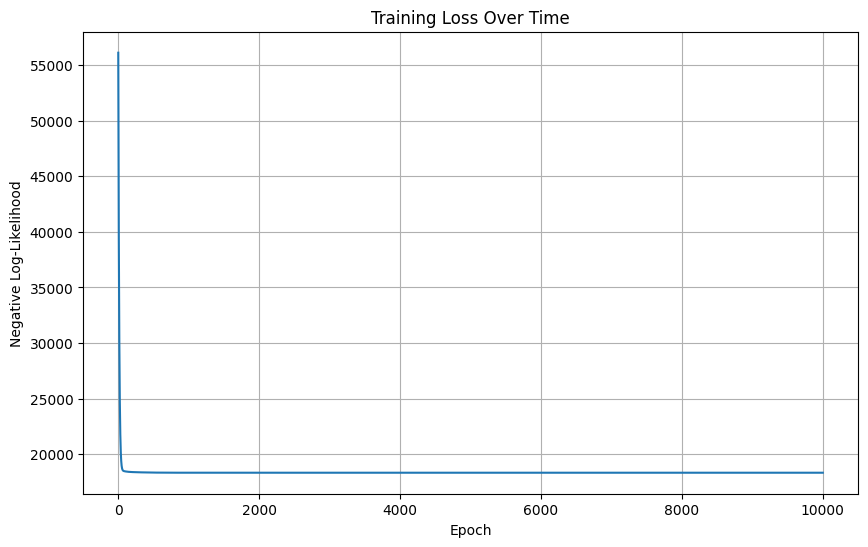

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(123)

# Step 1: Generate synthetic data based on a linear model
# y_i ~ N(X_i β, σ²)
n = 10000  # sample size
p = 1        # number of predictors (excluding intercept);

if p == 1:
    # For a single predictor, use linspace for clarity
    X = torch.linspace(0, 10, n).reshape(-1, p)  # Design matrix (without intercept)
else:
    # For multiple predictors, generate random features in [0, 10)
    X = torch.rand(n, p) * 10

# True parameters: Choose random intercept and slopes (shape: (p+1, 1))
# Using standard normal draws (you can scale or shift as needed)
true_beta = torch.randn(p+1, 1)
true_sigma = 1.5  # standard deviation of the error term

# Generate response variable with noise (μ = Xβ, σ = true_sigma)
X_with_intercept = torch.cat([torch.ones(n, 1), X], dim=1)  # Add intercept column
mu = X_with_intercept @ true_beta  # μ = Xβ
epsilon = torch.randn(n, 1) * true_sigma  # ε ~ N(0, σ²)
y = mu + epsilon  # y = Xβ + ε

# Step 2: Define the linear model as y ~ N(Xβ, σ²)
# The model now deduces the input dimension from an example design matrix.
class LinearModel(nn.Module):
    def __init__(self, example_x):
        super(LinearModel, self).__init__()
        input_dim = example_x.shape[-1]  # Deduce the number of predictors
        self.beta = nn.Parameter(torch.randn(input_dim + 1, 1))  # β vector includes intercept
        self.log_sigma = nn.Parameter(torch.tensor(0.0))  # log(σ) for numerical stability
        
    def forward(self, x):
        x_with_intercept = torch.cat([torch.ones(x.size(0), 1), x], dim=1)
        mu = x_with_intercept @ self.beta  # μ = Xβ
        return mu
    
    def sigma(self):
        return torch.exp(self.log_sigma)  # Convert log(σ) to σ
    
    def negative_log_likelihood(self, x, y):
        mu = self(x)
        sigma = self.sigma()
        # Negative log-likelihood for normal distribution
        return (torch.log(sigma) + 0.5 * ((y - mu) / sigma)**2).sum() + 0.5 * np.log(2 * np.pi) * y.numel()
    
# Step 3: Instantiate model and optimizer using X to deduce input dimension
model = LinearModel(X)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the model with timing
import time

num_epochs = 10000
losses = []
start_time = time.time()  # Start the timer

for epoch in range(num_epochs):
    # Compute negative log-likelihood
    loss = model.negative_log_likelihood(X, y)
    losses.append(loss.item())
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], NLL: {loss.item():.4f}')

elapsed_time = time.time() - start_time  # Stop the timer
print(f"Training completed in {elapsed_time:.2f} seconds")

# Step 5: Extract learned parameters
learned_beta = model.beta.data.flatten()
learned_sigma = model.sigma().item()

print(f'Learned parameters:')
print(f'β = {learned_beta.tolist()}')
print(f'σ = {learned_sigma:.4f}')
print(f'True parameters:')
print(f'β = {true_beta.flatten().tolist()}')
print(f'σ = {true_sigma:.4f}')

# Step 6: Plot results (only if p==1)
if p == 1:
    plt.figure(figsize=(10, 6))
    
    # Plot training data
    plt.scatter(X.numpy(), y.numpy(), label='Observations', s=1)
    
    # Plot the true regression line
    x_range = np.linspace(0, 10, 100).reshape(-1, 1)
    x_range_with_intercept = np.column_stack([np.ones(100), x_range])
    plt.plot(x_range, x_range_with_intercept @ true_beta.numpy(), 'r', 
             label=f'True: y = {true_beta[0].item():.2f} + {true_beta[1].item():.2f}x')
    
    # Plot the fitted regression line
    with torch.no_grad():
        y_pred = model(torch.FloatTensor(x_range))
    plt.plot(x_range, y_pred.numpy(), 'g--', 
             label=f'Fitted: y = {learned_beta[0].item():.2f} + {learned_beta[1].item():.2f}x')
    
    # Plot confidence bands (μ ± 2σ)
    plt.fill_between(
        x_range.flatten(),
        (x_range_with_intercept @ learned_beta.unsqueeze(1).numpy() - 2 * learned_sigma).reshape(-1),
        (x_range_with_intercept @ learned_beta.unsqueeze(1).numpy() + 2 * learned_sigma).reshape(-1),
        alpha=0.2, color='g', label=f'95% Confidence Band (σ = {learned_sigma:.2f})'
    )
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Gaussian Regression with Fixed Effects (β) and Standard Deviation (σ)')
    plt.grid(True)
    plt.show()
else:
    print("Skipping plot since p > 1 (plotting only works for a single predictor).")

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

$$y \sim \mathcal{N}(\mu, \sigma^2) $$



$$ p(y \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi},\sigma}\exp\left(-\frac{1}{2}\left(\frac{y-\mu}{\sigma}\right)^2\right) $$

$$ -\log p(y \mid \mu, \sigma) = \frac{1}{2}\log(2\pi) + \log(\sigma) + \frac{1}{2}\left(\frac{y-\mu}{\sigma}\right)^2 $$

In [2]:
# Logistic Regression GLM with Fixed Effects β

# Generate synthetic binary classification data
n = 50000  # sample size
p = 4      # number of predictors (excluding intercept); change as needed

if p == 1:
    # For a single predictor, use linspace for clarity
    X = torch.linspace(0, 10, n).reshape(-1, p)  # Design matrix (without intercept)
else:
    # For multiple predictors, generate random features in [0, 10)
    X = torch.rand(n, p) * 10

# True parameters: fixed effects vector β including an intercept (shape: (p+1, 1))
beta_true = torch.randn(p + 1, 1)

# Create design matrix with intercept
X_with_intercept = torch.cat([torch.ones(n, 1), X], dim=1)

# Compute true logits and probabilities via the logistic function
logits_true = X_with_intercept @ beta_true
probabilities = torch.sigmoid(logits_true)

# Generate binary outcomes: y ~ Bernoulli(probabilities)
y = torch.bernoulli(probabilities)

# Define the LogisticRegression as a GLM
class LogisticRegression(nn.Module):
    def __init__(self, example_x):
        super(LogisticRegression, self).__init__()
        input_dim = example_x.shape[-1]  # Deduce number of predictors
        # Initialize fixed effects vector β (including intercept)
        self.beta = nn.Parameter(torch.zeros(input_dim + 1, 1))
        
    def forward(self, x):
        # Append a column of ones for the intercept
        x_with_intercept = torch.cat([torch.ones(x.size(0), 1), x], dim=1)
        logits = x_with_intercept @ self.beta  # Compute the logit: Xβ
        return logits

    def negative_log_likelihood(self, x, y):
        logits = self.forward(x)
        # Ensure y has the same shape as logits
        y = y.view_as(logits)
        # Compute predictions using the sigmoid function
        p = torch.sigmoid(logits)
        # For numerical stability, add a small epsilon inside the logarithms
        eps = 1e-8
        loss = -(y * torch.log(p + eps) + (1 - y) * torch.log(1 - p + eps)).sum()
        return loss

# Instantiate the model and an optimizer
model_logistic = LogisticRegression(X)
optimizer_logistic = torch.optim.Adam(model_logistic.parameters(), lr=0.01)

# Train the logistic regression model and time the process
num_epochs = 10000
losses_logistic = []
import time
start_time = time.time()  # Start timer

for epoch in range(num_epochs):
    loss = model_logistic.negative_log_likelihood(X, y)
    losses_logistic.append(loss.item())
    
    optimizer_logistic.zero_grad()
    loss.backward()
    optimizer_logistic.step()
    
    # Print progress every 1000 epochs
    if (epoch+1) % 2000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], NLL: {loss.item():.4f}')

elapsed_time = time.time() - start_time  # Stop timer
print(f"Training completed in {elapsed_time:.2f} seconds")

# Step: Extract and compare the learned β
learned_beta_logistic = model_logistic.beta.data.flatten()
print("Learned β:", learned_beta_logistic.tolist())
print("True β:   ", beta_true.flatten().tolist())

Epoch [2000/10000], NLL: 4419.2778
Epoch [4000/10000], NLL: 4419.1875
Epoch [6000/10000], NLL: 4419.1880
Epoch [8000/10000], NLL: 4419.1885
Epoch [10000/10000], NLL: 4419.1885
Training completed in 14.19 seconds
Learned β: [0.5296468734741211, 0.007098494563251734, 1.4427294731140137, -0.5504682660102844, 0.6211622357368469]
True β:    [0.6077058911323547, 0.00535381305962801, 1.444969654083252, -0.5697283148765564, 0.6388015747070312]


Epoch [1000/10000], NLL: -972.5348
Epoch [2000/10000], NLL: -972.9594
Epoch [3000/10000], NLL: -972.9594
Epoch [4000/10000], NLL: -972.9594
Epoch [5000/10000], NLL: -972.9593
Epoch [6000/10000], NLL: -972.9594
Epoch [7000/10000], NLL: -972.9594
Epoch [8000/10000], NLL: -972.9594
Epoch [9000/10000], NLL: -972.9594
Epoch [10000/10000], NLL: -972.9594
Training completed in 3.94 seconds
Learned β: [-0.009324193000793457, 0.3192569315433502]
True β:    [-0.16778278350830078, 0.3469291627407074]


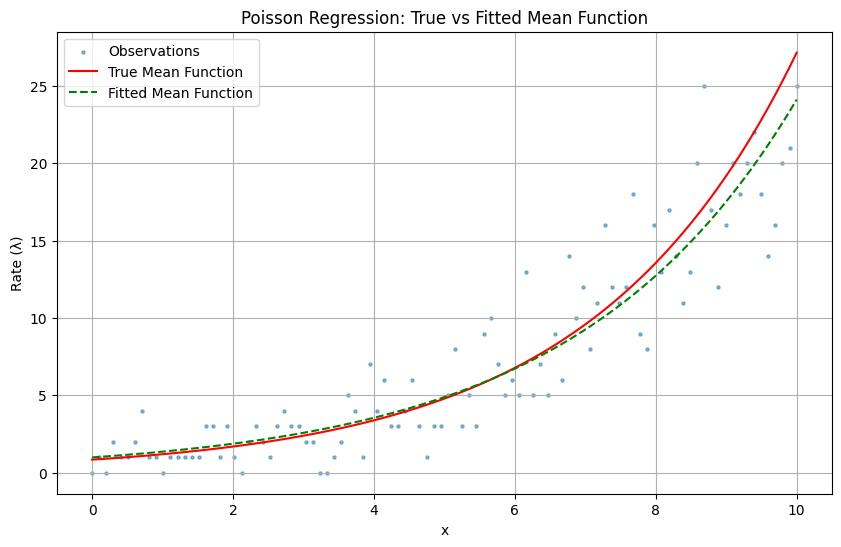

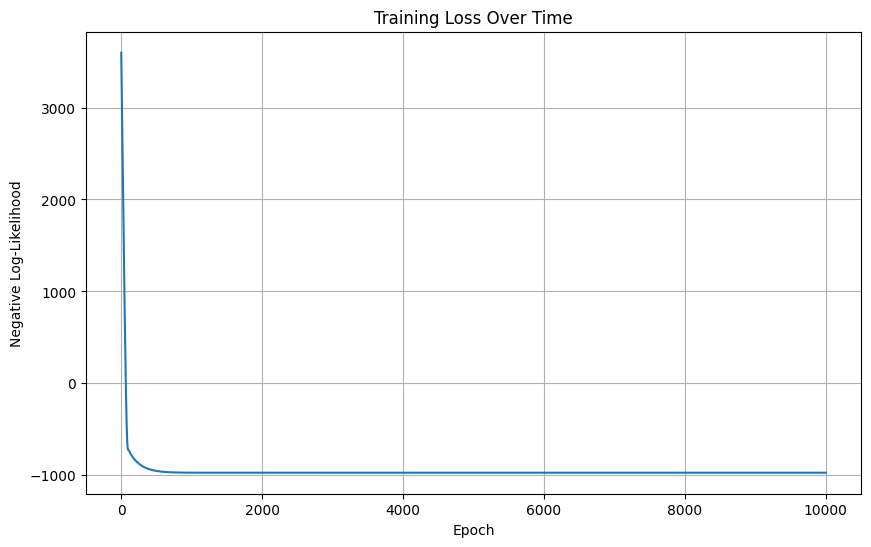

In [3]:
# Poisson Regression GLM with Fixed Effects β

# Generate synthetic count data for Poisson regression
n = 100  # sample size
p = 1      # number of predictors (excluding intercept); change as needed

if p == 1:
    # For a single predictor, use linspace for clarity
    X = torch.linspace(0, 10, n).reshape(-1, p)  # Design matrix (without intercept)
else:
    # For multiple predictors, generate random features in [0, 10)
    X = torch.rand(n, p) * 10

# True parameters: fixed effects vector β (including an intercept)
beta_true = torch.randn(p + 1, 1)

# Create design matrix with intercept
X_with_intercept = torch.cat([torch.ones(n, 1), X], dim=1)

# Compute the linear predictor η and the rate λ using the log link: λ = exp(η)
eta = X_with_intercept @ beta_true
lambda_true = torch.exp(eta)

# Generate observed count responses: y ~ Poisson(λ)
y = torch.poisson(lambda_true)

# Define the PoissonRegression as a GLM
class PoissonRegression(nn.Module):
    def __init__(self, example_x):
        super(PoissonRegression, self).__init__()
        input_dim = example_x.shape[-1]  # Deduce number of predictors
        # Initialize fixed effects vector β (including intercept)
        self.beta = nn.Parameter(torch.randn(input_dim + 1, 1))
        
    def forward(self, x):
        # Append a column of ones for the intercept
        x_with_intercept = torch.cat([torch.ones(x.size(0), 1), x], dim=1)
        eta = x_with_intercept @ self.beta
        # Use the log link to compute the rate λ = exp(η)
        return torch.exp(eta)
    
    def negative_log_likelihood(self, x, y):
        # Compute the negative log likelihood for Poisson regression (omitting the constant log(y!))
        x_with_intercept = torch.cat([torch.ones(x.size(0), 1), x], dim=1)
        eta = x_with_intercept @ self.beta
        lambda_pred = torch.exp(eta)
        # Poisson negative log-likelihood: ∑ [λ - y * η]
        return (lambda_pred - y * eta).sum()

# Instantiate the model and an optimizer
model_poisson = PoissonRegression(X)
optimizer_poisson = optim.Adam(model_poisson.parameters(), lr=0.01)

# Train the Poisson regression model and time the process
num_epochs = 10000
losses_poisson = []
import time
start_time = time.time()  # Start timer

for epoch in range(num_epochs):
    loss = model_poisson.negative_log_likelihood(X, y)
    losses_poisson.append(loss.item())
    
    optimizer_poisson.zero_grad()
    loss.backward()
    optimizer_poisson.step()
    
    # Print progress every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], NLL: {loss.item():.4f}')

elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time:.2f} seconds")

# Extract learned parameters
learned_beta_poisson = model_poisson.beta.data.flatten()
print("Learned β:", learned_beta_poisson.tolist())
print("True β:   ", beta_true.flatten().tolist())

# Plot results (only if p==1)
if p == 1:
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of observed counts
    plt.scatter(X.numpy(), y.numpy(), label='Observations', s=5, alpha=0.5)
    
    # Create a dense grid for plotting the mean function
    x_range = torch.linspace(0, 10, 100).reshape(-1, 1)
    ones_range = torch.ones(x_range.size(0), 1)
    X_range_with_intercept = torch.cat([ones_range, x_range], dim=1)
    
    # Compute the true mean function: λ = exp(X*β_true)
    true_lambda_range = torch.exp(X_range_with_intercept @ beta_true).detach().numpy()
    
    # Compute the fitted mean function using the learned β
    fitted_lambda_range = model_poisson(x_range).detach().numpy()
    
    plt.plot(x_range.numpy(), true_lambda_range, 'r', label='True Mean Function')
    plt.plot(x_range.numpy(), fitted_lambda_range, 'g--', label='Fitted Mean Function')
    
    plt.xlabel('x')
    plt.ylabel('Rate (λ)')
    plt.title('Poisson Regression: True vs Fitted Mean Function')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot the loss curve
    plt.figure(figsize=(10,6))
    plt.plot(range(num_epochs), losses_poisson)
    plt.xlabel('Epoch')
    plt.ylabel('Negative Log-Likelihood')
    plt.title('Training Loss Over Time')
    plt.grid(True)
    plt.show()
else:
    print("Plotting configured only for a single predictor (p==1).")